In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
#import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss

In [2]:
datadir = 'input/'
gatrain = pd.read_csv(os.path.join(datadir,'gender_age_train.csv'),
                      index_col='device_id')
gatest = pd.read_csv(os.path.join(datadir,'gender_age_test.csv'),
                     index_col = 'device_id')
phone = pd.read_csv(os.path.join(datadir,'phone_brand_device_model.csv'))
# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first').set_index('device_id')
events = pd.read_csv(os.path.join(datadir,'events.csv'),
                     parse_dates=['timestamp'], index_col='event_id')
appevents = pd.read_csv(os.path.join(datadir,'app_events.csv'), 
                        usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
applabels = pd.read_csv(os.path.join(datadir,'app_labels.csv'))

In [3]:
gatrain['trainrow'] = np.arange(gatrain.shape[0])
gatest['testrow'] = np.arange(gatest.shape[0])

In [4]:
m = phone.phone_brand.str.cat(phone.device_model)
modelencoder = LabelEncoder().fit(m)
phone['model'] = modelencoder.transform(m)
gatrain['model'] = phone['model']
gatest['model'] = phone['model']
Xtr_model = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.model)))
Xte_model = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.model)))
print('Model features: train shape {}, test shape {}'.format(Xtr_model.shape, Xte_model.shape))

Model features: train shape (74645, 1667), test shape (112071, 1667)


In [5]:
Xtrain = Xtr_model
Xtest =  Xte_model
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 1667), test shape (112071, 1667)


In [6]:
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)

In [7]:
def score(clf, random_state = 22):
    kf = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=random_state)
    pred = np.zeros((y.shape[0],nclasses))
    for itrain, itest in kf:
        Xtr, Xte = Xtrain[itrain, :], Xtrain[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        pred[itest,:] = clf.predict_proba(Xte)
        # Downsize to one fold only for kernels
        #return log_loss(yte, pred[itest, :])
        #print("{:.5f}".format(log_loss(yte, pred[itest,:])), end=' ')
    #print('')
    print("{:.5f}".format(log_loss(y, pred)), end=' ')
    return log_loss(y, pred)

[  1.00000000e-05   5.99484250e-05   3.59381366e-04   2.15443469e-03
   1.29154967e-02   7.74263683e-02   4.64158883e-01   2.78255940e+00
   1.66810054e+01   1.00000000e+02]
2.48183 2.47099 2.44679 2.42531 2.41081 2.39717 2.39477 2.41363 2.45437 2.50852 

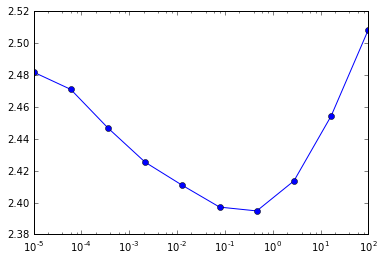

In [8]:
Cs = np.logspace(-5,2,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C, n_jobs=-1)))
plt.semilogx(Cs, res,'-o');

2.39586 2.39375 2.39370 2.39427 2.39508 2.39600 2.39697 2.39794 2.39891 2.39986 

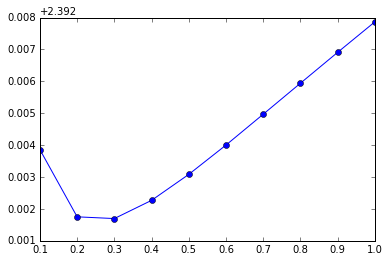

In [13]:
Cs = np.linspace(0.1,1,10)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.plot(Cs, res,'-o');

[ 0.2         0.22222222  0.24444444  0.26666667  0.28888889  0.31111111
  0.33333333  0.35555556  0.37777778  0.4       ]
2.39375 2.39365 2.39361 2.39362 2.39366 2.39374 2.39385 2.39397 2.39411 2.39427 

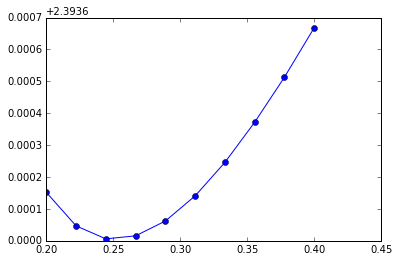

In [14]:
Cs = np.linspace(0.2,0.4,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.plot(Cs, res,'-o');

In [15]:
score(LogisticRegression(C=0.24444444))

2.39361 

2.3936071341920084

In [16]:
score(LogisticRegression(C=0.24444444, multi_class='multinomial',solver='lbfgs'))

2.39363 

2.3936253782856634

In [17]:
brandencoder = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = brandencoder.transform(phone['phone_brand'])
gatrain['brand'] = phone['brand']
gatest['brand'] = phone['brand']
Xtr_brand = csr_matrix((np.ones(gatrain.shape[0]), 
                       (gatrain.trainrow, gatrain.brand)))
Xte_brand = csr_matrix((np.ones(gatest.shape[0]), 
                       (gatest.testrow, gatest.brand)))
print('Brand features: train shape {}, test shape {}'.format(Xtr_brand.shape, Xte_brand.shape))

Brand features: train shape (74645, 131), test shape (112071, 131)


In [18]:
Xtrain = hstack((Xtr_brand, Xtr_model), format='csr')
Xtest =  hstack((Xte_brand, Xte_model), format='csr')
print('All features: train shape {}, test shape {}'.format(Xtrain.shape, Xtest.shape))

All features: train shape (74645, 1798), test shape (112071, 1798)


[  1.00000000e-05   5.99484250e-05   3.59381366e-04   2.15443469e-03
   1.29154967e-02   7.74263683e-02   4.64158883e-01   2.78255940e+00
   1.66810054e+01   1.00000000e+02]
2.48128 2.46860 2.43932 2.41089 2.39746 2.39124 2.39411 2.41558 2.45824 2.51399 

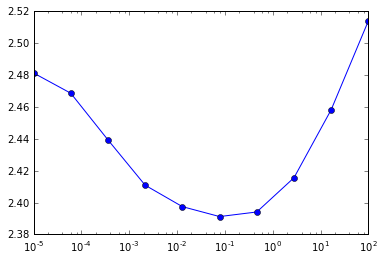

In [19]:
Cs = np.logspace(-5,2,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.semilogx(Cs, res,'-o');

[ 0.01        0.02555556  0.04111111  0.05666667  0.07222222  0.08777778
  0.10333333  0.11888889  0.13444444  0.15      ]
2.39880 2.39443 2.39276 2.39188 2.39136 2.39105 2.39087 2.39079 2.39076 2.39079 

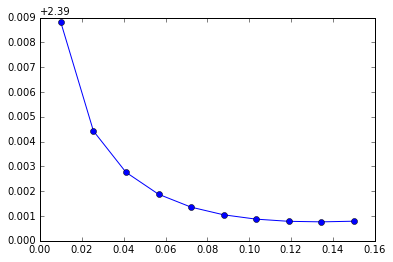

In [21]:
Cs = np.linspace(0.01,0.15,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.plot(Cs, res,'-o');

[ 0.1         0.11111111  0.12222222  0.13333333  0.14444444  0.15555556
  0.16666667  0.17777778  0.18888889  0.2       ]
2.39090 2.39082 2.39078 2.39076 2.39078 2.39081 2.39086 2.39092 2.39100 2.39108 

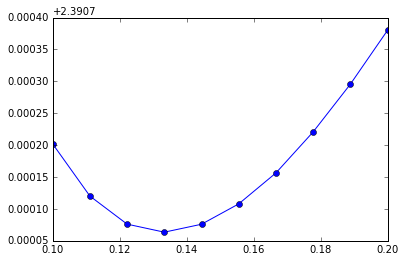

In [22]:
Cs = np.linspace(0.10,0.20,10)
print(Cs)
res = []
for C in Cs:
    res.append(score(LogisticRegression(C = C)))
plt.plot(Cs, res,'-o');

In [23]:
score(LogisticRegression(C=0.13333333))

2.39076 

2.3907632925125224

In [24]:
score(LogisticRegression(C=0.13333333, multi_class='multinomial',solver='lbfgs'))

2.39073 

2.3907330306542507